In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
symbol = "BTC-USD"
data = yf.download(symbol, start="2015-01-01", end="2025-01-01")

print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550
2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650
2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400
2015-01-04  264.195007  287.230011  257.612000  281.145996  55629100
2015-01-05  274.473999  278.341003  265.084015  265.084015  43962800


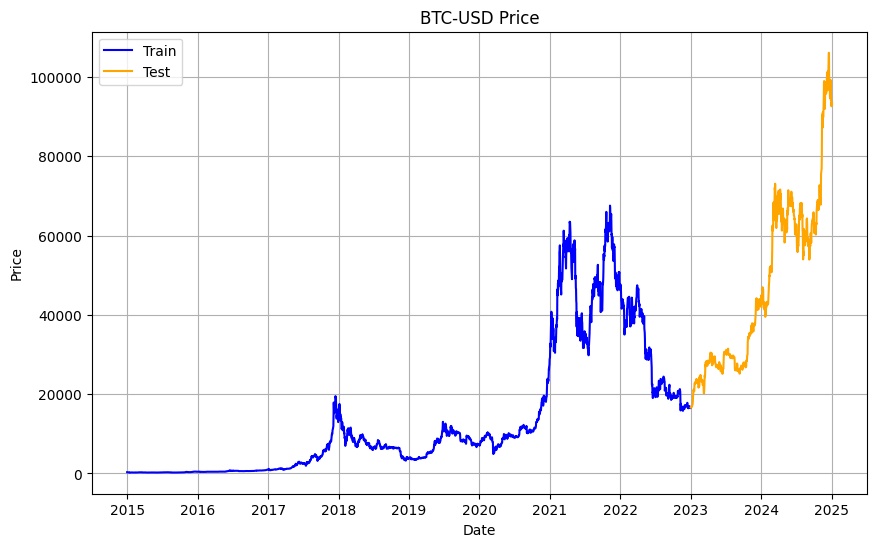

In [3]:
data = data[['Close']]

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.title('BTC-USD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [4]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)

test_scaled = scaler.transform(test_data)

In [24]:
timesteps = 100
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, timesteps)
X_test, y_test = create_sequences(test_scaled, timesteps)

print(f"(X_train): {X_train.shape}")
print(f"(y_train): {y_train.shape}")
print(f"(X_test): {X_test.shape}")
print(f"(y_test): {y_test.shape}")

(X_train): (2822, 100)
(y_train): (2822,)
(X_test): (631, 100)
(y_test): (631,)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.FloatTensor(X_train).reshape(-1, timesteps, 1).to(device)
y_train = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_test = torch.FloatTensor(X_test).reshape(-1, timesteps, 1).to(device)
y_test = torch.FloatTensor(y_test).reshape(-1, 1).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=4, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Dense layer for output
        self.dense = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x shape: (batch_size, train_seq_len, input_size)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, train_seq_len, hidden_size)

        # Take the last time step's output
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Dense layer
        out = self.dense(out)  # (batch_size, 1)
        return out

model = LSTMModel(input_size=1, hidden_size=50, num_layers=4, dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
    print(f'Test Loss: {test_loss.item():.6f}')

Epoch [10/100], Loss: 0.000288
Epoch [20/100], Loss: 0.000060
Epoch [30/100], Loss: 0.000347
Epoch [40/100], Loss: 0.000165
Epoch [50/100], Loss: 0.000079
Epoch [60/100], Loss: 0.000023
Epoch [70/100], Loss: 0.000165
Epoch [80/100], Loss: 0.003047
Epoch [90/100], Loss: 0.000104
Epoch [100/100], Loss: 0.000052
Test Loss: 0.014815


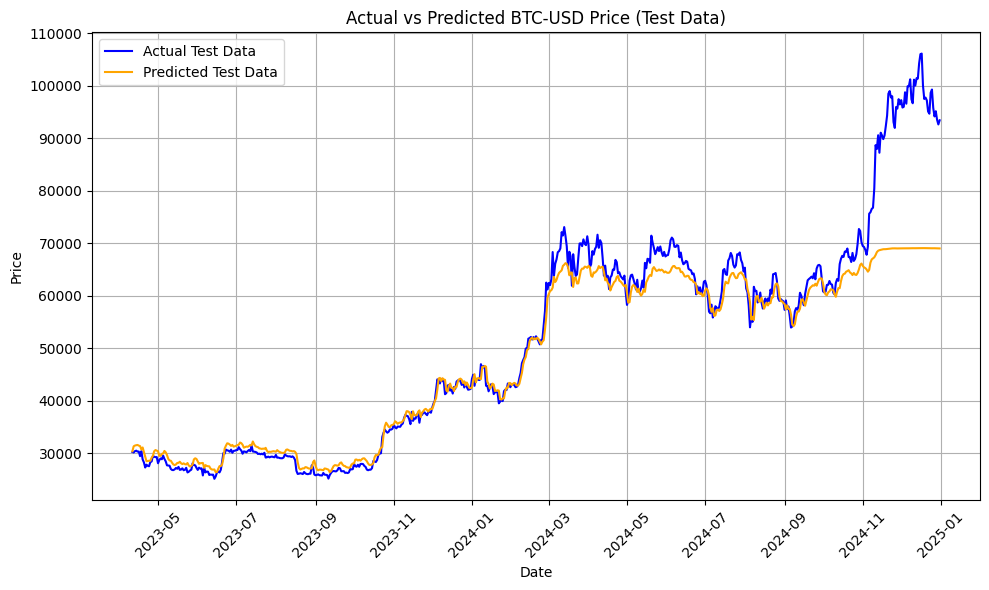

In [27]:
test_predictions_cpu = test_predictions.cpu().numpy()

test_predictions_cpu = scaler.inverse_transform(test_predictions_cpu)
y_test_inv = scaler.inverse_transform(y_test.cpu().numpy())

test_dates = test_data.index[timesteps:]

plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_inv, label='Actual Test Data', color='blue')
plt.plot(test_dates, test_predictions_cpu, label='Predicted Test Data', color='orange')
plt.title('Actual vs Predicted BTC-USD Price (Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

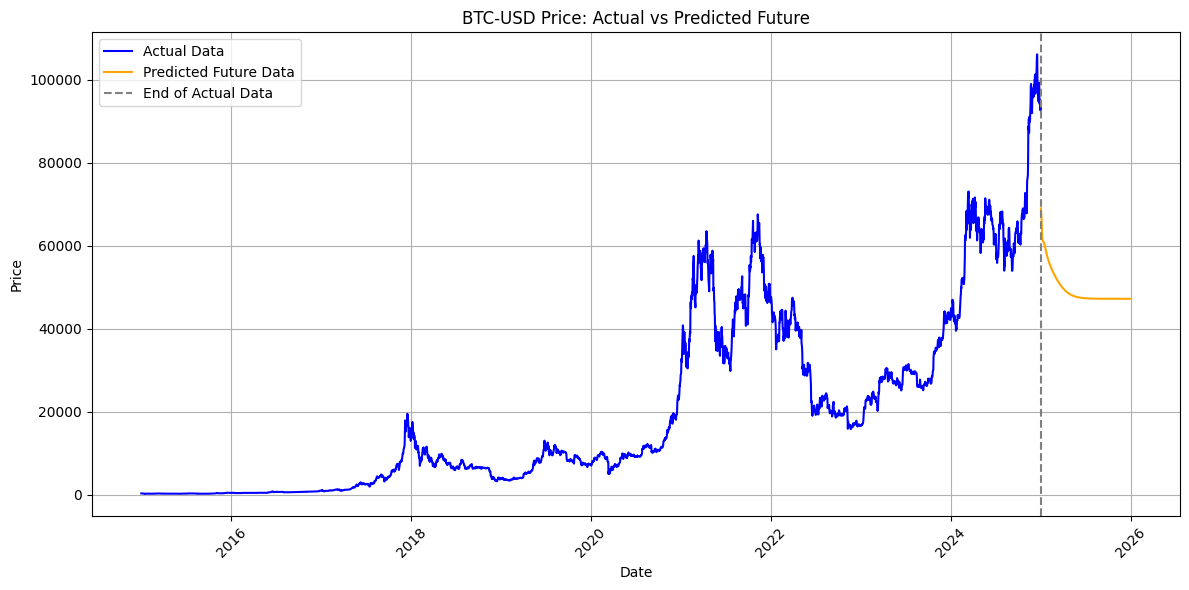

In [28]:
model.eval()

future_days = 365

last_sequence = test_scaled[-timesteps:].reshape(-1)
future_predictions = []

with torch.no_grad():
    current_sequence = last_sequence.copy()
    for _ in range(future_days):
        current_sequence_tensor = torch.FloatTensor(current_sequence).reshape(1, timesteps, 1).to(device)
        predicted_price = model(current_sequence_tensor).cpu().numpy()[0, 0]
        future_predictions.append(predicted_price)
        current_sequence = np.append(current_sequence[1:], predicted_price)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

all_dates = pd.concat([pd.Series(data.index), pd.Series(future_dates)]).reset_index(drop=True)
all_actual = np.concatenate([data['Close'].values.flatten(), np.full(future_days, np.nan)])
all_predicted = np.concatenate([np.full(len(data), np.nan), future_predictions.flatten()])

plt.figure(figsize=(12, 6))
plt.plot(all_dates[:len(data)], all_actual[:len(data)], label='Actual Data', color='blue')
plt.plot(all_dates[len(data)-timesteps:], all_predicted[len(data)-timesteps:], label='Predicted Future Data', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='End of Actual Data')
plt.title('BTC-USD Price: Actual vs Predicted Future')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()